<h4>Final set of features. 13-06-2024</h4>

In [4]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *
from tqdm import tqdm


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent.parent

In [5]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

<p>Load data for the pump event</p>

In [9]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="NEBLBTC", time="2018-12-23 16:59:55", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    end: pd.Timestamp = pump.time.round("1h") - timedelta(hours=1)
    start: pd.Timestamp = end - lookback_delta
    
    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in tqdm(date_range):
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name)
        )
        
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    return df

<h4>Load data</h4>

In [10]:
df = load_data(pump=pump, lookback_delta=timedelta(days=7))
df["quote"] = df["qty"] * df["price"]

100%|██████████| 8/8 [00:00<00:00, 33.10it/s]


<p>Perform aggregation by tick time into a single order (rush orders)</p>

In [12]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]


df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0
df_trades["quote_long"] = df_trades["quote_abs"] * df_trades["is_long"]
df_trades["quote_short"] = df_trades["quote_abs"] * ~df_trades["is_long"]

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long,quote_long,quote_short
0,2018-12-16 16:00:39.630,0.000282,0.000282,0.000282,0.000282,-8.22,8.22,-0.002321,0.002321,False,0.000000,0.002321
1,2018-12-16 16:01:06.142,0.000284,0.000284,0.000284,0.000284,10.63,10.63,0.003022,0.003022,True,0.003022,0.000000


In [13]:
# calculate slippages
df_trades["quote_slippage_abs"] = (
    df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])

In [14]:
# define upper bound up to which our model has data
time_ub: pd.Timestamp = pump.time.round("1h") - timedelta(hours=1)

<p>Now we work with aggregated rush orders to create features. First we will start with simplest features like hourly log returns</p>

<h4>Hourly candles features</h4>

In [15]:
hour_offsets: List[int] = [1, 3, 6, 12, 24, 48, 60, 72]

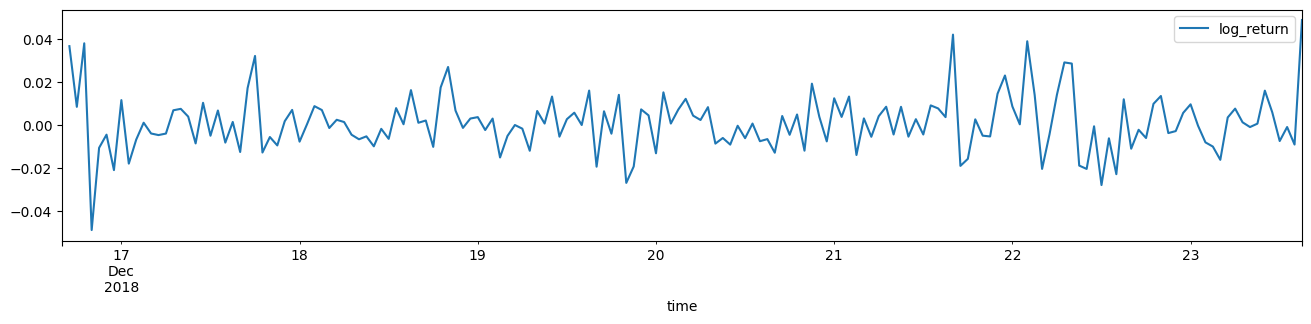

In [16]:
df_hourly_candles: pd.DataFrame = df_trades.resample(
    on="time", rule="1h", closed="left"
).agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    volume=("qty_abs", "sum"),
    volume_quote=("quote_abs", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
).reset_index()

df_hourly_candles["log_return"] = np.log(df_hourly_candles["close"] / df_hourly_candles["close"].shift(1))

df_hourly_candles.plot(x="time", y="log_return", figsize=(16, 3))
plt.show()

In [17]:
df_hourly_candles.head(2)

,time,open,close,low,high,volume,volume_quote,quote_slippage_abs,log_return
0,2018-12-16 16:00:00,0.000282,0.000283,0.000280,0.000285,4573.96,1.293015,0.004929,NaN
1,2018-12-16 17:00:00,0.000283,0.000294,0.000282,0.000298,47524.69,13.884760,0.041677,0.03672


<p>Following methodology of Xu and Livshits 2019, we calculate overall log return and hourly log returns volatility over different windows</p>

We will scale absolute features like volumes and quote quantities by long run std

SLR - scaled by long run std </br>
MLR - scaled by long run mean

In [18]:
# find long_run std values
long_run_volume_std: float = df_hourly_candles["volume"].std()
long_run_volume_quote_std: float = df_hourly_candles["volume_quote"].std()

In [22]:
hourly_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window: pd.DataFrame = df_hourly_candles[df_hourly_candles["time"] >= time_ub - timedelta(hours=offset)].copy()
    # calculate features over these windows
    hourly_features[f"overall_return_{offset}h"] = (df_window["log_return"] + 1).prod() # overall log return
    
    if offset == 1:
        continue

    hourly_features[f"log_return_std_{offset}h"] = df_window["log_return"].std()
    hourly_features[f"log_return_skew_{offset}h"] = df_window["log_return"].skew()
    hourly_features[f"volume_std_{offset}h_SLR"] = df_window["volume"].std() / long_run_volume_std # see how volatility in volume relates to long run volatility
    hourly_features[f"volume_quote_std_{offset}h_SLR"] = df_window["volume_quote"].std() / long_run_volume_quote_std

<p>We anticipate to see that the last hour prior to the pump will have the most volume and number trades out of all in the last week</p>

In [24]:
# indicator variable of the last hour being highest in volume
df_hourly_candles_1d: pd.DataFrame = df_hourly_candles[
    df_hourly_candles["time"] >= time_ub - timedelta(days=1)
].copy()

hourly_features["is_last_hour_highest_quote_vol_24h"] = (
    df_hourly_candles_1d["volume_quote"].iloc[-1] == df_hourly_candles_1d["volume_quote"].max()
)

In [28]:
# check if the last hour prior to the pump has the highest log return
hourly_features["is_last_hour_highest_log_return_24h"] = (
    df_hourly_candles_1d["log_return"].iloc[-1] == df_hourly_candles_1d["log_return"].max()
)

<p>Now we expand on the features set proposed in other papers, hopefully  this will allow us to improve the models</p>

<h4>Slippage features</h4>

$$
\text{Slippage Loss} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} \: - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\substack{\text{Quote could have been spent} \\ \text{if filled at best price}}}
$$

This formula calculates the slippage loss as the difference between quote we actually spent and quote amount we would have paid if we were able to execute at the best bid or ask price (depending on the side of the trade)

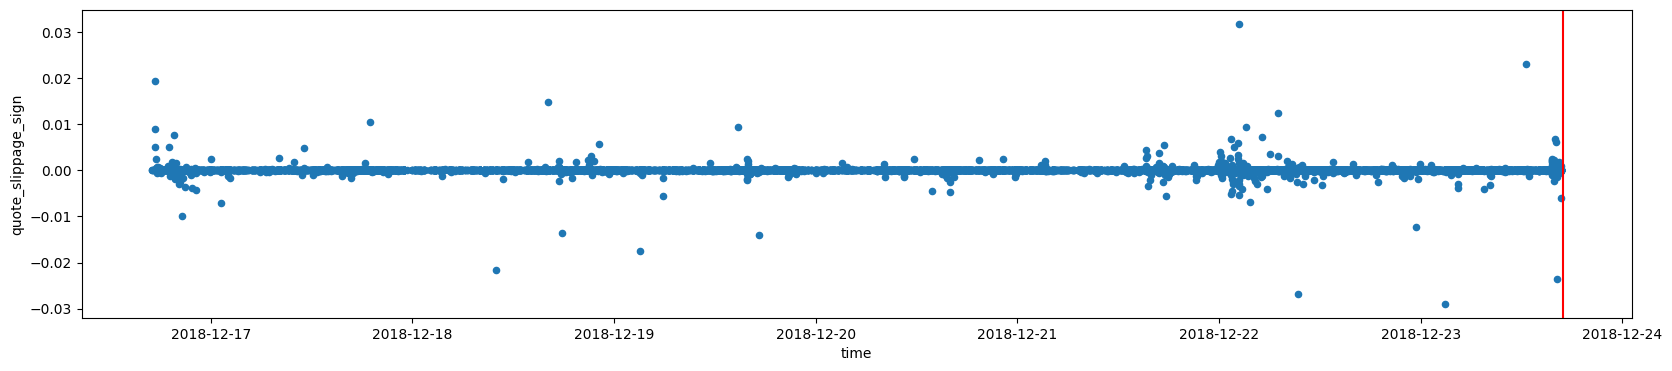

In [14]:
# find quote slippage for each trade

df_trades.plot.scatter(x="time", y="quote_slippage_sign", figsize=(20, 4))

plt.axvline(x=pump.time, color="red")
plt.show()

<p>We will use the same hourly offsets to calculate other features based on quote slippage imbalance</p>

In [15]:
from scipy.stats import powerlaw

In [16]:
df_trades["quote_slippage_long"] = df_trades["quote_slippage_abs"] * df_trades["is_long"]
df_trades["quote_slippage_short"] = df_trades["quote_slippage_abs"] * (~df_trades["is_long"])

df_72h = df_trades[
    df_trades["time"] >= time_ub - timedelta(hours=72)
].copy()

In [17]:
quote_slippage_features: Dict[str, float] = {}
powerlaw_features: Dict[str, float] = {}

cutoff_percentile: float = 0.99 # fit powerlaw to higher quantiles
 
for offset in hour_offsets:
    df_window = df_trades[df_trades["time"] >= time_ub - timedelta(hours=offset)].copy()

    quote_slippage_features[f"quote_slippage_imbalance_{offset}h"] = df_window["quote_slippage_sign"].sum() / df_window["quote_slippage_abs"].sum()
    # Share of slippage of this window in total 72h window 
    quote_slippage_features[f"quote_slippage_share_{offset}h_72h"] = df_window["quote_slippage_abs"].sum() / df_72h["quote_slippage_abs"].sum()
    # Share of long slippages in total 72h window, we expect higher values for each window for pumped tickers
    quote_slippage_features[f"quote_slippage_long_share_{offset}h_72h"] = (
        df_window["quote_slippage_long"].sum() / df_72h["quote_slippage_long"].sum()
    )
    # Fit powerlaw to measure spread in the upper quantiles
    quote_slippage_long: pd.Series = df_window[
        df_window["quote_slippage_long"] >= df_window["quote_slippage_long"].quantile(cutoff_percentile)
    ]["quote_slippage_long"]

    powerlaw_features[f"quote_slippage_long_powerlaw_alpha_{offset}h"] = (
        powerlaw.fit(quote_slippage_long)[0] + 1
    )

quote_slippage_features

{'quote_slippage_imbalance_1h': -0.16290404609259168,
 'quote_slippage_share_1h_72h': 0.11985178622360618,
 'quote_slippage_long_share_1h_72h': 0.10693179189791273,
 'quote_slippage_imbalance_3h': -0.054439760704541464,
 'quote_slippage_share_3h_72h': 0.1433833225070951,
 'quote_slippage_long_share_3h_72h': 0.14450235746460524,
 'quote_slippage_imbalance_6h': 0.15443035053889476,
 'quote_slippage_share_6h_72h': 0.1865386558350921,
 'quote_slippage_long_share_6h_72h': 0.22952165659768242,
 'quote_slippage_imbalance_12h': 0.07676665987438715,
 'quote_slippage_share_12h_72h': 0.2104766251544089,
 'quote_slippage_long_share_12h_72h': 0.2415530704238402,
 'quote_slippage_imbalance_24h': -0.23131123471847104,
 'quote_slippage_share_24h_72h': 0.33377518489248154,
 'quote_slippage_long_share_24h_72h': 0.27345865263379077,
 'quote_slippage_imbalance_48h': -0.08530864543054759,
 'quote_slippage_share_48h_72h': 0.9164740014302173,
 'quote_slippage_long_share_48h_72h': 0.893473784664958,
 'quote_s

In [18]:
# check if the last hour prior to the pump is highest in the last 24hours in terms quote slippages
quote_slippage_features["is_last_hour_highest_quote_slippage_abs"] = (
    df_hourly_candles_1d["quote_slippage_abs"].iloc[-1] == df_hourly_candles_1d["quote_slippage_abs"].max()
)

<h4>Volume Imbalance features</h4>

In [19]:
volume_imbalance_features: Dict[str, float] = {}

for offset in hour_offsets:
    df_window = df_trades[df_trades["time"] >= time_ub - timedelta(hours=offset)].copy()
    volume_imbalance_features[f"volume_quote_imbalance_{offset}h"] = df_window["quote_sign"].sum() / df_window["quote_abs"].sum()

<h4>Short run features, study everything happening within the last hour prior to the pump</h4>

In [20]:
short_run_features: Dict[str, float] = {}

df_1h = df_trades[df_trades["time"] >= time_ub - timedelta(hours=1)].copy()
df_24h = df_trades[df_trades["time"] >= time_ub - timedelta(hours=24)].copy()

short_run_features["quote_slippage_long_share_1h_24h"] = df_1h["quote_slippage_long"].sum() / df_24h["quote_slippage_long"].sum()
# Share of trades in the last hour in the last 24 hours
short_run_features["num_trades_share_1h_24h"] = df_1h.shape[0] / df_24h.shape[0]
short_run_features["num_long_trades_share_1h_24h"] = df_1h["is_long"].sum() / df_24h["is_long"].sum()

short_run_features

{'quote_slippage_long_share_1h_24h': 0.3910345892075801,
 'num_trades_share_1h_24h': 0.21520175164216454,
 'num_long_trades_share_1h_24h': 0.1936640765092648}

<h4>Average time between orders as a measure of market activity</h4>

<p>We may compare to see how activity increases in the run up to the pump</p>

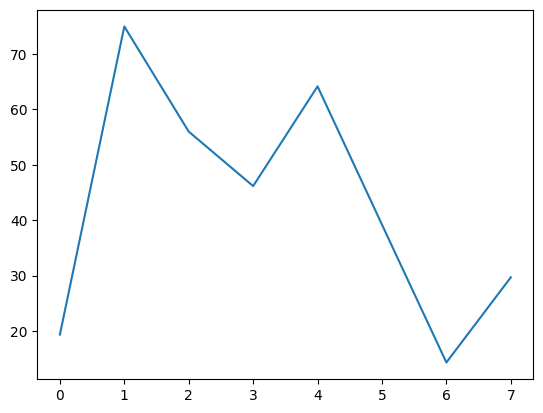

In [54]:
other_features: Dict[str, float] = {}

time_between_trades: List[int] = []

for ts, df_res in df_trades.resample(on="time", rule="1d"):
    time_between_trades.append(
        df_res["time"].diff().dt.total_seconds().mean()
    )

plt.plot(time_between_trades)